This notebook is was created for lab meeting 8/1/23 to compare various powerband selection algo's

In [ ]:
import polars as pl

: 

In [4]:
import altair as alt
import polars as pl
import pandas as pd
import sys
import visualization_functions.altair_utils as alt_utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
import joypy
import glob
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from collections import OrderedDict

In [6]:
from model_development.powerband_selection.powerband_identification import leave_one_session_out_cross_validation, get_training_data_for_model, load_training_data_from_db

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from model_development.embedded_model_classes import TwoStepLDATree

In [9]:
from aquarel import load_theme
import vapeplot

theme = load_theme("minimal_light")
theme.apply()
vapeplot.set_palette('jazzcup')

In [7]:
# Import data to polars dataframes
parts = OrderedDict()
parts_sfs = OrderedDict()
parts_sfs_kfold = OrderedDict()
parts_sfs_kfold_rem = OrderedDict()
parts_cluster = OrderedDict()
parts_sfs_rem = OrderedDict()
parts_sfs_2lda = OrderedDict()
parts_sfs_2lda_rem = OrderedDict()
parts_sfs_dt = OrderedDict()
parts_sfs_dt_rem = OrderedDict()

parts_sfs_sub = OrderedDict()
parts_sfs_cort = OrderedDict()
parts_sfs_sub_rem = OrderedDict()
parts_sfs_cort_rem = OrderedDict()

pattern = '/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/'

for device in ['RCS02L', 'RCS02R', 'RCS03L', 'RCS03R', 'RCS07L', 'RCS07R', 'RCS09L', 'RCS09R', 'RCS16L', 'RCS16R']:
    print(device)
    parts_sfs[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/all_tds/*/*.parquet')[0])
    parts_sfs_kfold[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_band_same_folds/*/*.parquet')[0])
    parts_sfs_kfold_rem[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_band_same_folds_rem/*/*.parquet')[0])
    parts_sfs_rem[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_bands_REM/*/*.parquet')[0])
    parts_sfs_dt[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_band_DT_SLS/*/*.parquet')[0])
    parts_sfs_dt_rem[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_band_DT_REM/*/*.parquet')[0])
    parts_sfs_2lda[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_band_2LDA_SLS/*/*.parquet')[0])
    parts_sfs_2lda_rem[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_band_2LDA_REM/*/*.parquet')[0])
    
    parts_sfs_sub[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_band_subcortical_sls_no_constraint/*/*.parquet')[0])
    parts_sfs_cort[device] = pl.read_parquet((glob.glob(pattern + f'{device[3:]}/sfs_band_key2_sls_no_constraint/*/*.parquet')[0]))
    parts_sfs_sub_rem[device] = pl.read_parquet((glob.glob(pattern + f'{device[3:]}/sfs_band_subcortical_rem_no_constraint/*/*.parquet')[0]))
    parts_sfs_cort_rem[device] = pl.read_parquet((glob.glob(pattern + f'{device[3:]}/sfs_band_key2_rem_no_constraint/*/*.parquet')[0])) 

for device in ['RCS02L', 'RCS02R', 'RCS03L', 'RCS03R', 'RCS07L', 'RCS07R', 'RCS09L', 'RCS09R', 'RCS16L', 'RCS16R']:
    parts_cluster[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/sfs_cluster_3/*/*.parquet')[0])



RCS02L
RCS02R
RCS03L
RCS03R
RCS07L
RCS07R
RCS09L
RCS09R
RCS16L
RCS16R
['/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/02L/sfs_cluster_3/2023-08-01_11-52-17/powerband_search_results_2023-08-01_11-52-17.parquet']
['/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/02R/sfs_cluster_3/2023-08-01_11-52-17/powerband_search_results_2023-08-01_11-52-17.parquet']
['/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/03L/sfs_cluster_3/2023-08-01_11-52-17/powerband_search_results_2023-08-01_11-52-17.parquet']
['/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/03R/sfs_cluster_3/2023-08-01_11-52-17/powerband_search_results_2023-08-01_11-52-17.parquet']
['/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/07L/sfs_cluster_3/2023-08-01_11-52-17/powerband_search_results_2023-08-01_11-52-17.parquet']
['/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identi

In [5]:
parts_cluster['RCS02L'].sort('AUC', descending=True).head()

PB1_index,PB2_index,PB3_index,PB4_index,Acc,AUC,BalAcc,TPR,Precision,TNR,Acc_std,AUC_std,BalAcc_std,TPR_std,precision_std,TNR_std,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std,PB1_channel_freq_range,PB2_channel_freq_range,PB3_channel_freq_range,PB4_channel_freq_range
list[i64],list[i64],list[i64],list[i64],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64,struct[2],struct[2],struct[2],struct[2]
"[596, 608]","[626, 1032]","[1044, 1051]","[515, 518]",0.580026,0.653582,0.500561,0.99983,0.579855,0.001291,0.00004,0.004186,0.000066,0.000059,0.000023,0.000177,"[0.882263, 0.931034, … 0.885882]","[0.938063, 0.983528, … 0.961319]","[0.866667, 0.951872, … 0.852747]","[0.938503, 0.927083, … 0.92823]","[""02L_05-03-22"", ""02L_05-04-22"", … ""02L_04-21-22""]",0.90148,0.963586,0.910603,0.922226,0.02027,0.015692,0.033131,0.029046,"{""TD_key2"",[40.77, 47.12]}","{""Invalid"",[-1.0, -1.0]}","{""TD_key3"",[9.52, 13.43]}","{""TD_key2"",[1.22, 3.17]}"
"[596, 614]","[515, 518]","[1044, 1051]","[619, 1032]",0.580045,0.652687,0.500586,0.999814,0.579868,0.001358,0.000049,0.007261,0.000062,0.000041,0.000029,0.000148,"[0.879205, 0.931034, … 0.882353]","[0.940185, 0.98466, … 0.963288]","[0.864198, 0.954545, … 0.852747]","[0.935829, 0.92487, … 0.921615]","[""02L_05-03-22"", ""02L_05-04-22"", … ""02L_04-21-22""]",0.902099,0.964984,0.913681,0.920397,0.020688,0.015182,0.034794,0.029283,"{""TD_key2"",[40.77, 50.05]}","{""TD_key2"",[1.22, 3.17]}","{""TD_key3"",[9.52, 13.43]}","{""Invalid"",[-1.0, -1.0]}"
"[553, 564]","[596, 614]","[1044, 1051]","[619, 1032]",0.579816,0.650576,0.500317,0.999798,0.579736,0.000835,0.000071,0.008792,0.000076,0.000057,0.000043,0.000165,"[0.882263, 0.931034, … 0.896471]","[0.933442, 0.984769, … 0.959633]","[0.883951, 0.959893, … 0.896703]","[0.92268, 0.920513, … 0.908686]","[""02L_05-03-22"", ""02L_05-04-22"", … ""02L_04-21-22""]",0.900958,0.962346,0.935744,0.902319,0.02359,0.018182,0.028661,0.035657,"{""TD_key2"",[19.78, 25.63]}","{""TD_key2"",[40.77, 50.05]}","{""TD_key3"",[9.52, 13.43]}","{""Invalid"",[-1.0, -1.0]}"
"[596, 608]","[553, 564]","[626, 1032]","[1044, 1051]",0.579853,0.649633,0.50036,0.999806,0.579757,0.000913,0.000134,0.004622,0.00015,0.000065,0.000077,0.000289,"[0.880734, 0.932534, … 0.892941]","[0.930547, 0.983601, … 0.957274]","[0.883951, 0.962567, … 0.885714]","[0.920308, 0.920716, … 0.911765]","[""02L_05-03-22"", ""02L_05-04-22"", … ""02L_04-21-22""]",0.899919,0.960416,0.932827,0.902701,0.022956,0.019017,0.029044,0.034055,"{""TD_key2"",[40.77, 47.12]}","{""TD_key2"",[19.78, 25.63]}","{""Invalid"",[-1.0, -1.0]}","{""TD_key3"",[9.52, 13.43]}"
"[553, 564]","[1067, 1078]","[515, 518]","[619, 1032]",0.579891,0.649095,0.500392,0.999871,0.579773,0.000913,0.000093,0.011407,0.000126,0.000047,0.000053,0.000283,"[0.845566, 0.923538, … 0.86]","[0.895235, 0.970241, … 0.951281]","[0.787654, 0.877005, … 0.769231]","[0.95509, 0.984985, … 0.961538]","[""02L_05-03-22"", ""02L_05-04-22"", … ""02L_04-21-22""]",0.883956,0.944217,0.842646,0.956548,0.026781,0.0241,0.037647,0.020536,"{""TD_key2"",[19.78, 25.63]}","{""TD_key3"",[20.75, 26.61]}","{""TD_key2"",[1.22, 3.17]}","{""Invalid"",[-1.0, -1.0]}"


In [6]:
parts_sfs_rem['RCS02L'].head()

PB0_index,PB1_index,PB2_index,PB3_index,sfs_scores,Acc,AUC,BalAcc,TPR,Precision,TNR,Acc_std,AUC_std,BalAcc_std,TPR_std,precision_std,TNR_std,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std,PB0_channel_freq_range,PB1_channel_freq_range,PB2_channel_freq_range,PB3_channel_freq_range
list[i64],list[i64],list[i64],list[i64],list[f64],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64,struct[2],struct[2],struct[2],struct[2]
"[578, 586]","[1071, 1079]","[549, 551]","[1047, 1054]","[0.80447, 0.843659, … 0.872321]",0.860062,0.872321,0.615472,0.270732,0.534657,0.960212,0.010118,0.025666,0.024329,0.045452,0.065417,0.005812,"[0.869565, 0.938547, … 0.873208]","[0.87549, 0.906034, … 0.859558]","[0.1875, 0.333333, … 0.321429]","[0.405405, 0.466667, … 0.48]","[""02L_05-04-22"", ""02L_04-28-22"", … ""02L_04-22-22""]",0.858503,0.870463,0.244827,0.498022,0.035369,0.025415,0.049112,0.098732,"{""TD_key2"",[31.98, 36.38]}","{""TD_key3"",[22.71, 27.1]}","{""TD_key2"",[17.82, 19.29]}","{""TD_key3"",[10.99, 14.89]}"


In [7]:
def aggregate_sfs_scores(scores_dict):
    return pl.DataFrame(
        {'Participant': scores_dict.keys(), 
        'AUC': [scores_dict[key]['AUC'][0] for key in scores_dict.keys()], 
        'AUC_std': [scores_dict[key]['AUC_std'][0] for key in scores_dict.keys()], 
        'session_AUC': [scores_dict[key]['session_AUC_mean'][0] for key in scores_dict.keys()],
        'session_AUC_std': [scores_dict[key]['session_AUC_std'][0] for key in scores_dict.keys()],
        'Acc': [scores_dict[key]['Acc'][0] for key in scores_dict.keys()], 
        'Acc_std': [scores_dict[key]['Acc_std'][0] for key in scores_dict.keys()],
        'session_Acc': [scores_dict[key]['session_accuracy_mean'][0] for key in scores_dict.keys()],
        'session_Acc_std': [scores_dict[key]['session_accuracy_std'][0] for key in scores_dict.keys()]
        }).with_columns(pl.col('Participant').str.slice(3, 3))

In [8]:
keys = ['lda', 'lda_rem', '2lda', '2lda_rem',  'dt', 'dt_rem', 'sub', 'cort', 'sub_rem', 'cort_rem'] 
dict_dfs = [parts_sfs, parts_sfs_rem, parts_sfs_2lda, parts_sfs_2lda_rem, parts_sfs_dt, parts_sfs_dt_rem, parts_sfs_sub, parts_sfs_cort, parts_sfs_sub_rem, parts_sfs_cort_rem]
agg_df_dict = {key: aggregate_sfs_scores(dict_df) for key, dict_df in zip(keys, dict_dfs)}

In [87]:
def process_cluster_df_dict(df_dict):
    df_dict_top_pb = {}
    # Find channels that can feasibly be embedded onto device
    for key in df_dict.keys():
        print(key)
        df_dict_top_pb[key] = df_dict[key].filter(
                                (pl.col('PB1_index').list.concat(['PB2_index', 'PB3_index', 'PB4_index']).list.eval(pl.element().is_between(0,511)).list.sum() <= 4) &
                                (pl.col('PB1_index').list.concat(['PB2_index', 'PB3_index', 'PB4_index']).list.eval(pl.element().is_between(512,1023)).list.sum() <= 4) &
                                (pl.col('PB1_index').list.concat(['PB2_index', 'PB3_index', 'PB4_index']).list.eval(pl.element().is_between(1024,1535)).list.sum() <= 4)
        ).sort('AUC', descending=True).top_k(k=1, by='AUC')
    
    return aggregate_sfs_scores(df_dict_top_pb)

In [93]:
agg_cluster = process_cluster_df_dict(parts_cluster)
agg_df_dict['cluster'] = agg_cluster

RCS02L
RCS02R
RCS03L
RCS03R
RCS07L
RCS07R
RCS09L
RCS09R
RCS16L
RCS16R


In [92]:
agg_cluster.head()

Participant,AUC,AUC_std,session_AUC,session_AUC_std,Acc,Acc_std,session_Acc,session_Acc_std
str,f64,f64,f64,f64,f64,f64,f64,f64
"""02L""",0.967829,0.005423,0.964792,0.013598,0.91092,0.010127,0.907608,0.018578
"""02R""",0.971663,0.001717,0.969056,0.011746,0.914542,0.005483,0.910932,0.022108
"""03L""",0.952942,0.003951,0.935553,0.028253,0.860397,0.009858,0.841218,0.051861
"""03R""",0.94591,0.008827,0.742447,0.164952,0.836456,0.009761,0.697479,0.102634
"""07L""",0.906101,0.004865,0.907483,0.058743,0.830597,0.005694,0.849318,0.080482


In [11]:
base_path = '/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/baselines/'
keys = ['lda', 'lda_delta', 'lda_rem', '2lda', '2lda_rem',  'dt', 'dt_rem']
baselines_parqs = [
    'sls_baseline.parquet',
    'sls_delta.parquet',
    'rem_baselines.parquet',
    'baseline_2lda_sls.parquet',
    'baseline_2lda_rem.parquet',
    'baseline_dt_sls.parquet',
    'baseline_dt_rem.parquet'
]

bs_df_dict = {key: pl.read_parquet(base_path + parq) for key, parq in zip(keys, baselines_parqs)}

In [12]:
agg_df_dict['lda'].head()

Participant,AUC,AUC_std,session_AUC,session_AUC_std,Acc,Acc_std,session_Acc,session_Acc_std
str,f64,f64,f64,f64,f64,f64,f64,f64
"""02L""",0.962678,0.005993,0.959261,0.015476,0.86131,0.016813,0.861065,0.025062
"""02R""",0.973467,0.006383,0.971494,0.009746,0.912908,0.015359,0.910736,0.017535
"""03L""",0.953942,0.012434,0.948786,0.02173,0.861572,0.020503,0.845317,0.055515
"""03R""",0.945429,0.024349,0.94706,0.025132,0.836633,0.022535,0.827891,0.066465
"""07L""",0.898995,0.021549,0.910056,0.059526,0.814925,0.03293,0.836315,0.087939


Plotting

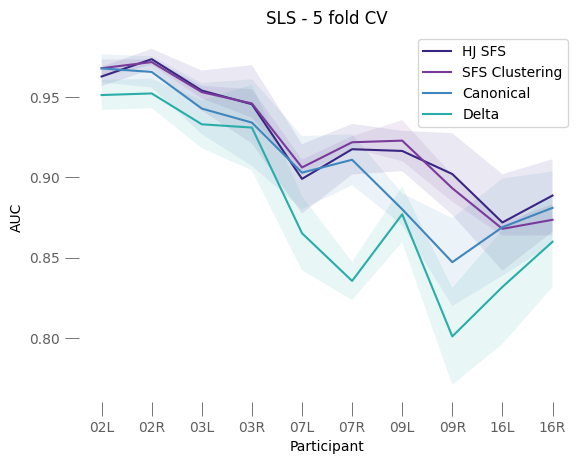

In [100]:
ax = sns.lineplot(data=agg_df_dict['lda'], x='Participant', y='AUC', label='HJ SFS')
ax.fill_between(agg_df_dict['lda']['Participant'], agg_df_dict['lda']['AUC'] - agg_df_dict['lda']['AUC_std'], agg_df_dict['lda']['AUC'] + agg_df_dict['lda']['AUC_std'], alpha=0.1)

ax = sns.lineplot(data=agg_df_dict['cluster'], x='Participant', y='AUC', label='SFS Clustering')
ax.fill_between(agg_df_dict['cluster']['Participant'], agg_df_dict['cluster']['AUC'] - agg_df_dict['cluster']['AUC_std'], agg_df_dict['cluster']['AUC'] + agg_df_dict['cluster']['AUC_std'], alpha=0.1)

ax = sns.lineplot(data=bs_df_dict['lda'], x='device', y='test_roc_auc', label='Canonical')
ax = ax.fill_between(bs_df_dict['lda']['device'], bs_df_dict['lda']['test_roc_auc'] - bs_df_dict['lda']['AUC_std'], bs_df_dict['lda']['test_roc_auc'] + bs_df_dict['lda']['AUC_std'], alpha=0.1)

ax = sns.lineplot(data=bs_df_dict['lda_delta'], x='device', y='test_roc_auc', label='Delta')
ax.fill_between(bs_df_dict['lda_delta']['device'], bs_df_dict['lda_delta']['test_roc_auc'] - bs_df_dict['lda_delta']['AUC_std'], bs_df_dict['lda_delta']['test_roc_auc'] + bs_df_dict['lda_delta']['AUC_std'], alpha=0.1)

plt.title('SLS - 5 fold CV')
plt.show()


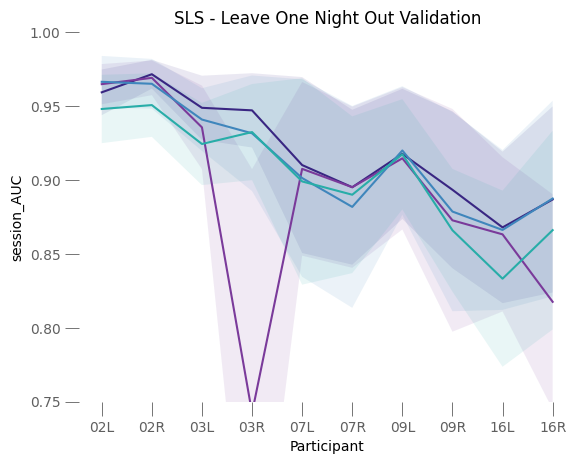

In [103]:
ax = sns.lineplot(data=agg_df_dict['lda'], x='Participant', y='session_AUC', label='HJ SFS')
ax.fill_between(agg_df_dict['lda']['Participant'], agg_df_dict['lda']['session_AUC'] - agg_df_dict['lda']['session_AUC_std'], agg_df_dict['lda']['session_AUC'] + agg_df_dict['lda']['session_AUC_std'], alpha=0.1)

ax = sns.lineplot(data=agg_df_dict['cluster'], x='Participant', y='session_AUC', label='SFS Cluster')
ax.fill_between(agg_df_dict['cluster']['Participant'], agg_df_dict['cluster']['session_AUC'] - agg_df_dict['cluster']['session_AUC_std'], agg_df_dict['cluster']['session_AUC'] + agg_df_dict['cluster']['session_AUC_std'], alpha=0.1)

ax = sns.lineplot(data=bs_df_dict['lda'], x='device', y='session_AUC_mean', label='Canonical')
ax = ax.fill_between(bs_df_dict['lda']['device'], bs_df_dict['lda']['session_AUC_mean'] - bs_df_dict['lda']['session_AUC_std'], bs_df_dict['lda']['session_AUC_mean'] + bs_df_dict['lda']['session_AUC_std'], alpha=0.1)

ax = sns.lineplot(data=bs_df_dict['lda_delta'], x='device', y='session_AUC_mean', label='Delta')
ax.fill_between(bs_df_dict['lda_delta']['device'], bs_df_dict['lda_delta']['session_AUC_mean'] - bs_df_dict['lda_delta']['session_AUC_std'], bs_df_dict['lda_delta']['session_AUC_mean'] + bs_df_dict['lda_delta']['session_AUC_std'], alpha=0.1)

plt.ylim(0.75, 1)
plt.legend().remove()
plt.title('SLS - Leave One Night Out Validation')
plt.show()

In [113]:
{key: parts_sfs_rem[key]['PB0_channel_freq_range'].to_list() for key in parts_sfs_rem.keys()}

{'RCS02L': [{'Channel': 'TD_key2', 'freq_range': [31.98, 36.38]}],
 'RCS02R': [{'Channel': 'TD_key2', 'freq_range': [31.98, 36.38]}],
 'RCS03L': [{'Channel': 'TD_BG', 'freq_range': [0.73, 1.22]}],
 'RCS03R': [{'Channel': 'TD_key2', 'freq_range': [8.06, 10.5]}],
 'RCS07L': [{'Channel': 'TD_key3', 'freq_range': [8.06, 11.47]}],
 'RCS07R': [{'Channel': 'TD_key3', 'freq_range': [5.13, 9.52]}],
 'RCS09L': [{'Channel': 'TD_key2', 'freq_range': [12.94, 13.92]}],
 'RCS09R': [{'Channel': 'TD_key2', 'freq_range': [12.94, 13.43]}],
 'RCS16L': [{'Channel': 'TD_key2', 'freq_range': [53.96, 58.35]}],
 'RCS16R': [{'Channel': 'TD_key2', 'freq_range': [13.43, 15.38]}]}

[1 2 3 4]
[0.96053835 0.96252783 0.96281996 0.96267842]
[1 2 3 4]
[0.96263403 0.96982726 0.97212138 0.97346684]
[1 2 3 4]
[0.9489614  0.95092613 0.95311537 0.95394233]
[1 2 3 4]
[0.94467623 0.94566495 0.94569998 0.94542904]
[1 2 3 4]
[0.89288278 0.89690995 0.89853518 0.8989949 ]
[1 2 3 4]
[0.91221501 0.91610934 0.9170691  0.91743985]
[1 2 3 4]
[0.91541687 0.91570472 0.91635761 0.91635821]
[1 2 3 4]
[0.86943044 0.88749776 0.89754998 0.90199399]
[1 2 3 4]
[0.84745013 0.86153828 0.87028898 0.87187687]
[1 2 3 4]
[0.86190751 0.87889098 0.88658841 0.88861454]


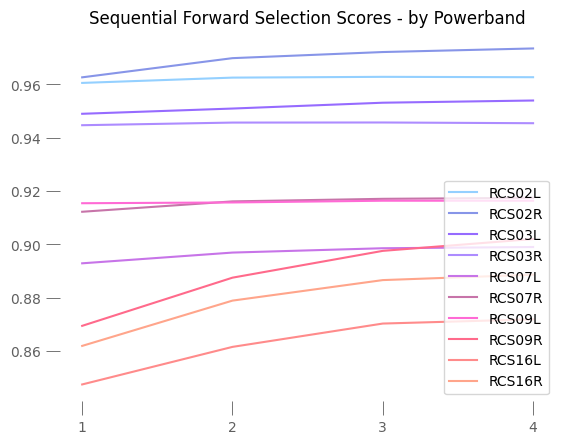

In [172]:
vapeplot.set_palette('vaporwave')
for key, df in parts_sfs.items():
    scores = df['sfs_scores'].to_numpy().squeeze()
    print(np.arange(1,5))
    print(scores)
    sns.lineplot(x=np.arange(1,5), y=scores, label=key)
plt.title('Sequential Forward Selection SLS Scores - by Powerband')
plt.xticks(np.arange(1,5))
plt.legend(loc='lower right')
plt.show()

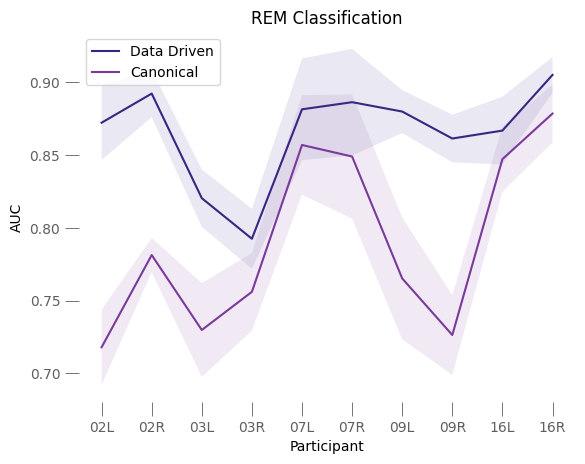

In [16]:
ax = sns.lineplot(data=agg_df_dict['lda_rem'], x='Participant', y='AUC', label='Data Driven')
ax.fill_between(agg_df_dict['lda_rem']['Participant'], agg_df_dict['lda_rem']['AUC'] - agg_df_dict['lda_rem']['AUC_std'], agg_df_dict['lda_rem']['AUC'] + agg_df_dict['lda_rem']['AUC_std'], alpha=0.1)

ax = sns.lineplot(data=bs_df_dict['lda_rem'], x='device', y='test_roc_auc', label='Canonical')
ax = ax.fill_between(bs_df_dict['lda_rem']['device'], bs_df_dict['lda_rem']['test_roc_auc'] - bs_df_dict['lda_rem']['AUC_std'], bs_df_dict['lda_rem']['test_roc_auc'] + bs_df_dict['lda_rem']['AUC_std'], alpha=0.1)

plt.title('REM Classification')
plt.show()

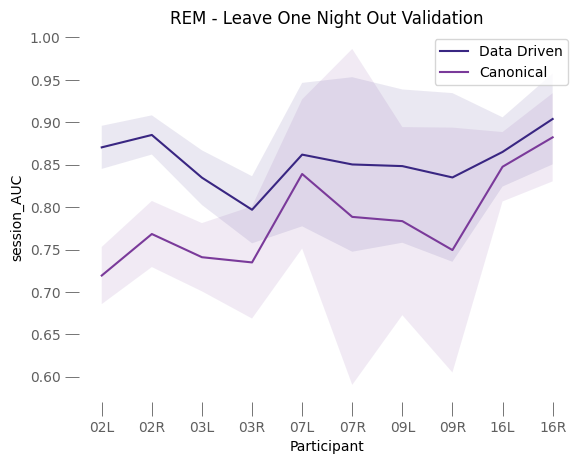

In [160]:
ax = sns.lineplot(data=agg_df_dict['lda_rem'], x='Participant', y='session_AUC', label='Data Driven')
ax.fill_between(agg_df_dict['lda_rem']['Participant'], agg_df_dict['lda_rem']['session_AUC'] - agg_df_dict['lda_rem']['session_AUC_std'], agg_df_dict['lda_rem']['session_AUC'] + agg_df_dict['lda_rem']['session_AUC_std'], alpha=0.1)

ax = sns.lineplot(data=bs_df_dict['lda_rem'], x='device', y='session_AUC_mean', label='Canonical')
ax = ax.fill_between(bs_df_dict['lda_rem']['device'], bs_df_dict['lda_rem']['session_AUC_mean'] - bs_df_dict['lda_rem']['session_AUC_std'], bs_df_dict['lda_rem']['session_AUC_mean'] + bs_df_dict['lda_rem']['session_AUC_std'], alpha=0.1)

plt.title('REM - Leave One Night Out Validation')
plt.show()

[1 2 3 4]
[0.8044705  0.843659   0.85460393 0.87232144]
[1 2 3 4]
[0.84843164 0.86478332 0.88415663 0.89235295]
[1 2 3 4]
[0.75870743 0.7393933  0.81536054 0.82043444]
[1 2 3 4]
[0.71801576 0.73987896 0.78053467 0.79254372]
[1 2 3 4]
[0.85124127 0.8729555  0.87823749 0.88153558]
[1 2 3 4]
[0.84885936 0.87307324 0.88082512 0.88642922]
[1 2 3 4]
[0.81462503 0.84275494 0.8733826  0.88000118]
[1 2 3 4]
[0.83594612 0.84900762 0.85816086 0.86144795]
[1 2 3 4]
[0.84282717 0.85589621 0.86310727 0.86689224]
[1 2 3 4]
[0.84626876 0.8876521  0.89974814 0.90517922]


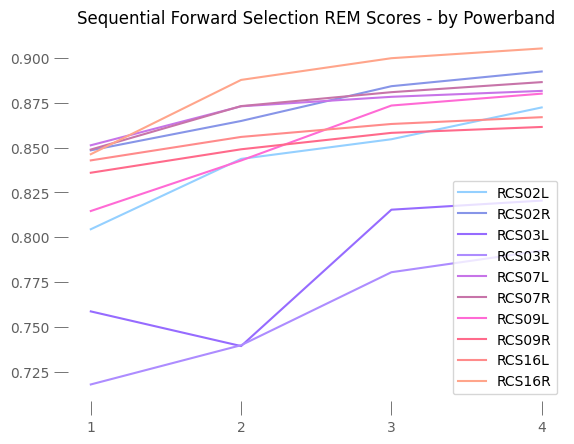

In [173]:
vapeplot.set_palette('vaporwave')
for key, df in parts_sfs_rem.items():
    scores = df['sfs_scores'].to_numpy().squeeze()
    print(np.arange(1,5))
    print(scores)
    sns.lineplot(x=np.arange(1,5), y=scores, label=key)
plt.title('Sequential Forward Selection REM Scores - by Powerband')
plt.xticks(np.arange(1,5))
plt.legend(loc='lower right')
plt.show()

RCS02L
[0.80555191 0.84340896 0.85279756 0.87165358]
RCS02R
[0.85064928 0.86541009 0.88628727 0.89508852]
RCS03L
[0.75890417 0.73951202 0.81655209 0.82267831]
RCS03R
[0.71858269 0.74756512 0.77751178 0.79662588]
RCS07L
[0.84936916 0.87175878 0.87777525 0.88091078]
RCS07R
[0.84895062 0.87315614 0.88104778 0.88707302]
RCS09L
[0.81378061 0.84319305 0.86112673 0.86954546]
RCS09R
[0.83680055 0.84949996 0.8595758  0.86319833]
RCS16L
[0.84281903 0.8560779  0.86362626 0.86719041]
RCS16R
[0.84680021 0.88708754 0.89236992 0.90439407]


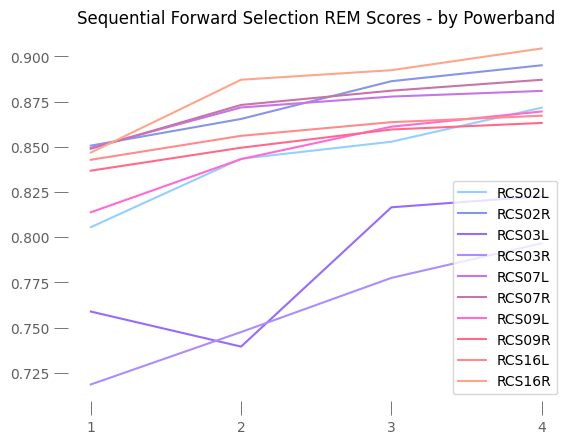

In [16]:
vapeplot.set_palette('vaporwave')
for key, df in parts_sfs_kfold_rem.items():
    scores = df['sfs_scores'].to_numpy().squeeze()
    print(key)
    print(scores)
    sns.lineplot(x=np.arange(1,5), y=scores, label=key)
plt.title('Sequential Forward Selection REM Scores - by Powerband')
plt.xticks(np.arange(1,5))
plt.legend(loc='lower right')
plt.show()

In [24]:
parts_sfs_cort_rem['RCS03L'].head()

PB0_index,PB1_index,PB2_index,PB3_index,sfs_scores,Acc,AUC,BalAcc,TPR,Precision,TNR,Acc_std,AUC_std,BalAcc_std,TPR_std,precision_std,TNR_std,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std,PB0_channel_freq_range,PB1_channel_freq_range,PB2_channel_freq_range,PB3_channel_freq_range
list[i64],list[i64],list[i64],list[i64],list[f64],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64,struct[2],struct[2],struct[2],struct[2]
"[2, 2]","[45, 53]","[104, 109]","[14, 16]","[0.739962, 0.800585, … 0.80984]",0.812197,0.80984,0.5,0.0,0.0,1.0,0.00036,0.022618,0.0,0.0,0.0,0.0,"[0.900463, 0.780534, … 0.757632]","[0.858014, 0.801488, … 0.826292]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","[""03L_05-20-22"", ""03L_05-23-22"", … ""03L_05-22-22""]",0.808937,0.821089,0.0,0.0,0.045305,0.030495,0.0,0.0,"{""TD_key2"",[0.73, 1.22]}","{""TD_key2"",[21.73, 26.12]}","{""TD_key2"",[50.54, 53.47]}","{""TD_key2"",[6.59, 8.06]}"


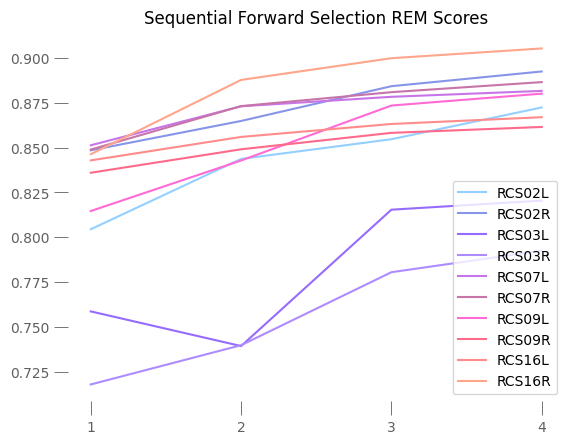

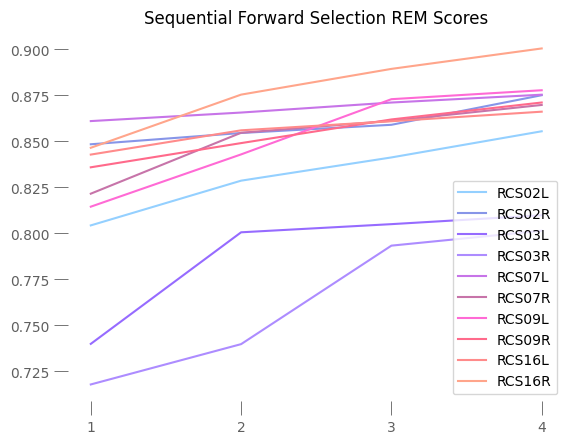

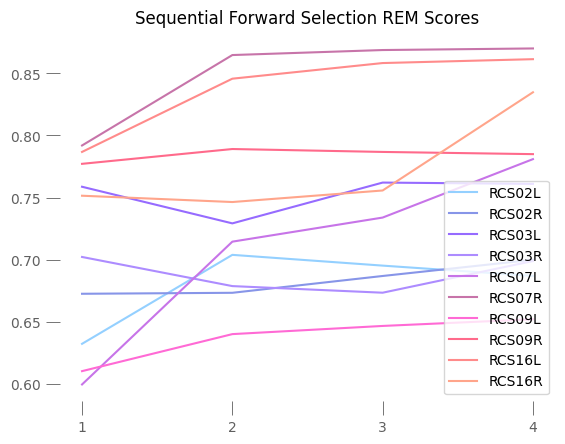

In [19]:
for dict_ in [parts_sfs_rem, parts_sfs_cort_rem, parts_sfs_sub_rem]:    
    vapeplot.set_palette('vaporwave')
    for key, df in dict_.items():
        scores = df['sfs_scores'].to_numpy().squeeze()
        print(key)
        print(df['sfs_features'])
        sns.lineplot(x=np.arange(1,5), y=scores, label=key)
    plt.title('Sequential Forward Selection REM Scores')
    plt.xticks(np.arange(1,5))
    plt.legend(loc='lower right')
    plt.show()

In [104]:
[print(parts_sfs_rem[key]['PB0_channel_freq_range']) for key in parts_sfs_rem.keys()]

shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[31.98, 36.38]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[31.98, 36.38]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[0.73, 1.22]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[8.06, 10.5]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[8.06, 11.47]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[5.13, 9.52]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[12.94, 13.92]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[12.94, 13.43]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[53.96, 58.35]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[13.43, 15.38]}
]


[None, None, None, None, None, None, None, None, None, None]

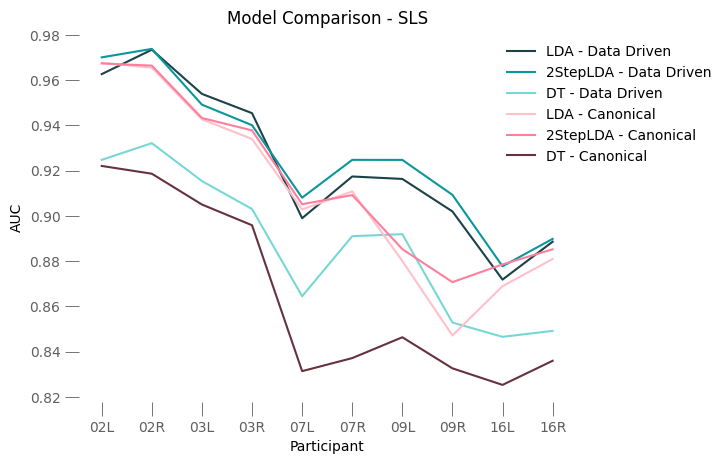

In [25]:
vapeplot.set_palette('macplus')
sns.lineplot(data=agg_df_dict['lda'], x='Participant', y='AUC', label='LDA - Data Driven')
sns.lineplot(data=agg_df_dict['2lda'], x='Participant', y='AUC', label='2StepLDA - Data Driven')
sns.lineplot(data=agg_df_dict['dt'], x='Participant', y='AUC', label='DT - Data Driven')
sns.lineplot(data=bs_df_dict['lda'], x='device', y='test_roc_auc', label='LDA - Canonical')
sns.lineplot(data=bs_df_dict['2lda'], x='device', y='test_roc_auc', label='2StepLDA - Canonical')
sns.lineplot(data=bs_df_dict['dt'], x='device', y='test_roc_auc', label='DT - Canonical')
#plt.legend(loc='upper right', frameon=False)
plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.title('Model Comparison - SLS')
plt.show()

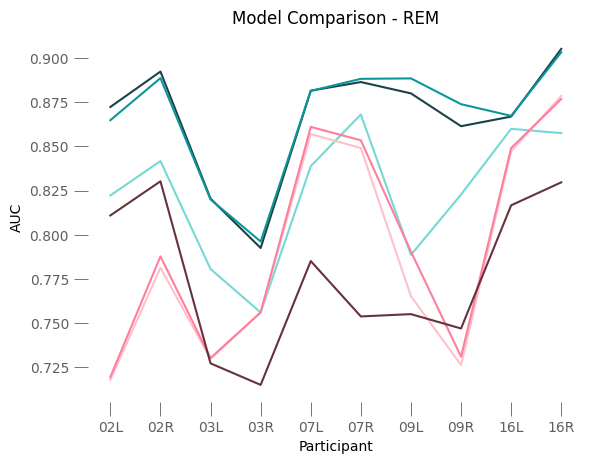

In [18]:
ax = sns.lineplot(data=agg_df_dict['lda_rem'], x='Participant', y='AUC', label='LDA - Data Driven')
ax = sns.lineplot(data=agg_df_dict['2lda_rem'], x='Participant', y='AUC', label='2StepLDA - Data Driven')
ax = sns.lineplot(data=agg_df_dict['dt_rem'], x='Participant', y='AUC', label='DT - Data Driven')
ax = sns.lineplot(data=bs_df_dict['lda_rem'], x='device', y='test_roc_auc', label='LDA - Canonical')
ax = sns.lineplot(data=bs_df_dict['2lda_rem'], x='device', y='test_roc_auc', label='2StepLDA - Canonical')
ax = sns.lineplot(data=bs_df_dict['dt_rem'], x='device', y='test_roc_auc', label='DT - Canonical')
plt.legend().remove()
plt.title('Model Comparison - REM')
plt.show()

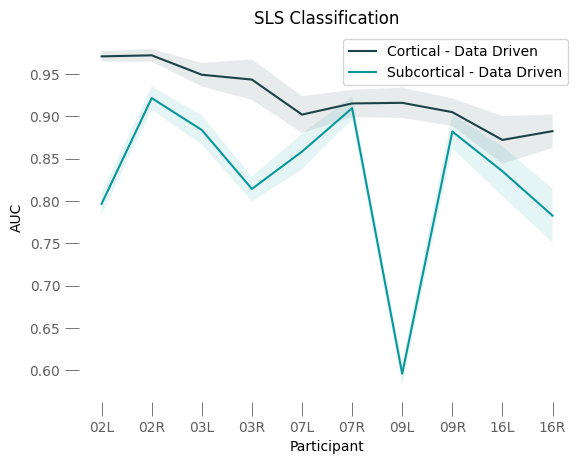

In [28]:
ax = sns.lineplot(data=agg_df_dict['cort'], x='Participant', y='AUC', label='Cortical - Data Driven')
ax.fill_between(agg_df_dict['cort']['Participant'], agg_df_dict['cort']['AUC'] - agg_df_dict['cort']['AUC_std'], agg_df_dict['cort']['AUC'] + agg_df_dict['cort']['AUC_std'], alpha=0.1)

ax = sns.lineplot(data=agg_df_dict['sub'], x='Participant', y='AUC', label='Subcortical - Data Driven')
ax.fill_between(agg_df_dict['sub']['Participant'], agg_df_dict['sub']['AUC'] - agg_df_dict['sub']['AUC_std'], agg_df_dict['sub']['AUC'] + agg_df_dict['sub']['AUC_std'], alpha=0.1)

plt.title('SLS Classification')
plt.show()

[1 2 3 4]
[0.9546328  0.96700985 0.96984675 0.97079071]
[1 2 3 4]
[0.95828737 0.96856888 0.97159427 0.97203162]
[1 2 3 4]
[0.94890146 0.94914928 0.94906123 0.94912574]
[1 2 3 4]
[0.94464878 0.94488    0.94447636 0.94338933]
[1 2 3 4]
[0.88304372 0.88628819 0.89998418 0.90207313]
[1 2 3 4]
[0.87915333 0.89541932 0.91111242 0.91523122]
[1 2 3 4]
[0.91531197 0.91525029 0.91459856 0.91596728]
[1 2 3 4]
[0.86950111 0.88754637 0.89822805 0.90495054]
[1 2 3 4]
[0.84037795 0.86275226 0.87118579 0.87216093]
[1 2 3 4]
[0.86187893 0.8789404  0.8819132  0.88249106]


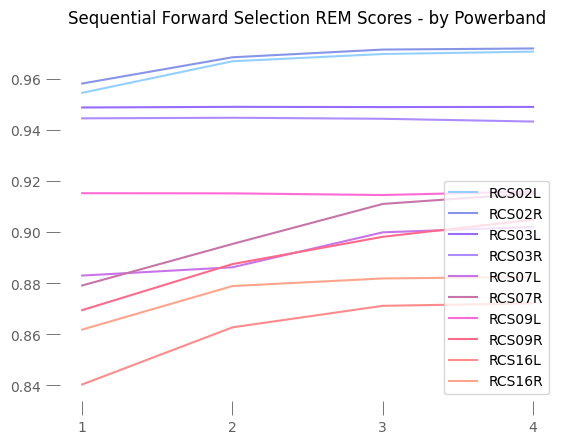

In [33]:
vapeplot.set_palette('vaporwave')
for key, df in parts_sfs_cort.items():
    scores = df['sfs_scores'].to_numpy().squeeze()
    print(np.arange(1,5))
    print(scores)
    sns.lineplot(x=np.arange(1,5), y=scores, label=key)
plt.title('Sequential Forward Selection REM Scores - by Powerband')
plt.xticks(np.arange(1,5))
plt.legend(loc='lower right')
plt.show()

In [34]:
[print(parts_sfs_sub[key]['PB0_channel_freq_range']) for key in parts_sfs_sub.keys()]

shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[23.19, 27.59]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[25.15, 29.54]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[1.22, 1.71]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[3.66, 5.62]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[33.45, 37.84]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[25.63, 30.03]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[49.07, 52.0]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[9.52, 13.92]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[28.56, 32.96]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[1.22, 2.2]}
]


[None, None, None, None, None, None, None, None, None, None]

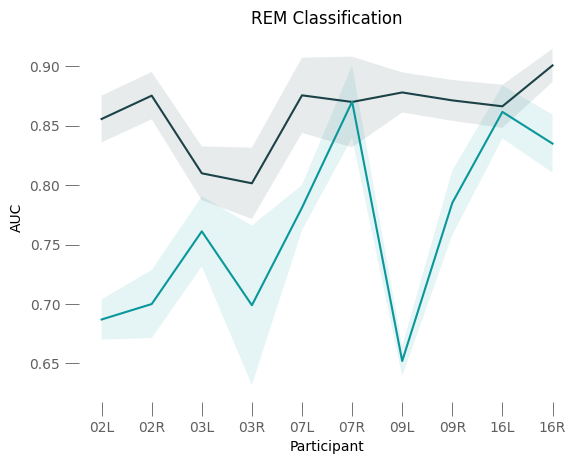

In [30]:

ax = sns.lineplot(data=agg_df_dict['cort_rem'], x='Participant', y='AUC', label='Cortical - Data Driven')
ax.fill_between(agg_df_dict['cort_rem']['Participant'], agg_df_dict['cort_rem']['AUC'] - agg_df_dict['cort_rem']['AUC_std'], agg_df_dict['cort_rem']['AUC'] + agg_df_dict['cort_rem']['AUC_std'], alpha=0.1)

ax = sns.lineplot(data=agg_df_dict['sub_rem'], x='Participant', y='AUC', label='Subcortical - Data Driven')
ax.fill_between(agg_df_dict['sub_rem']['Participant'], agg_df_dict['sub_rem']['AUC'] - agg_df_dict['sub_rem']['AUC_std'], agg_df_dict['sub_rem']['AUC'] + agg_df_dict['sub_rem']['AUC_std'], alpha=0.1)

plt.legend().remove()
plt.title('REM Classification')
plt.show()

Plot powerbands

In [61]:
def plot_powerband(pbs, fft_size, num_channels, legend=False, xlabel=False):
    print(pbs)
    plt.plot(np.arange(0, fft_size * num_channels), np.ones(fft_size * num_channels), color="white")
    colors = ["red", "green", "blue", "orange"]
    order = ['first', 'second', 'third', 'fourth']
    for i, pb in enumerate(pbs):
        plt.axvspan(pb[0], pb[1]+1, ymin=0, ymax=1, color=colors[i], label=order[i])
    plt.ylim(0, 1)
    plt.xlim(0, 120)
    plt.xticks(np.arange(0, 121, 10), np.arange(0, 61, 5))
    plt.tick_params(left=False, labelleft=False)
    if legend:
        plt.legend()
    if xlabel:
        plt.xlabel("Frequency (Hz)")
    plt.show()

In [131]:
np.stack(parts_sfs['RCS02R'].select(pl.col('^.*_index$')).to_numpy()[0])

array([[1027, 1030],
       [ 623,  631],
       [ 612,  620],
       [1051, 1054]])

RCS02L
[[48 56]
 [41 41]
 [ 2  2]
 [23 26]]


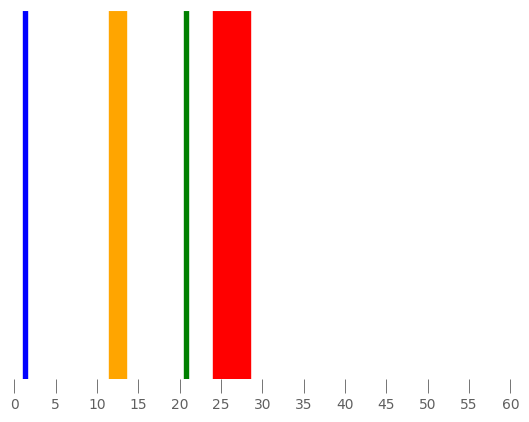

RCS02R
[[52 60]
 [60 64]
 [46 46]
 [34 34]]


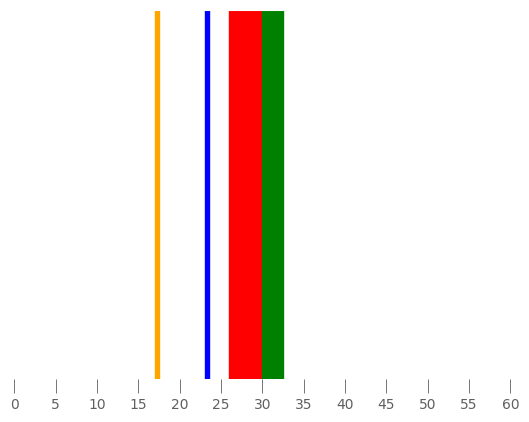

RCS03L
[[  3   3]
 [  2   5]
 [ 96 101]
 [ 29  31]]


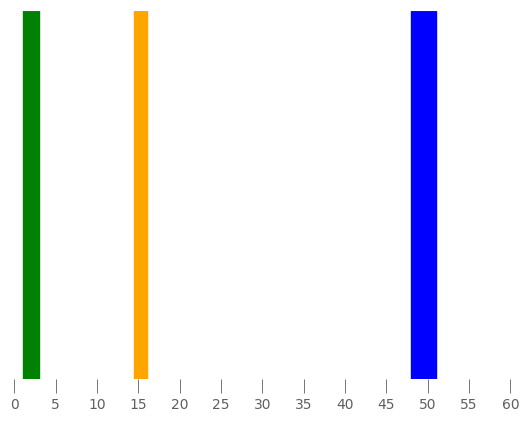

RCS03R
[[ 8 11]
 [45 53]
 [ 7 13]
 [ 3  3]]


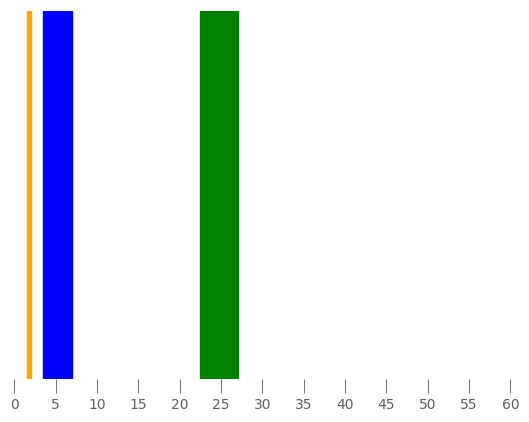

RCS07L
[[ 69  77]
 [115 115]
 [117 117]
 [ 34  35]]


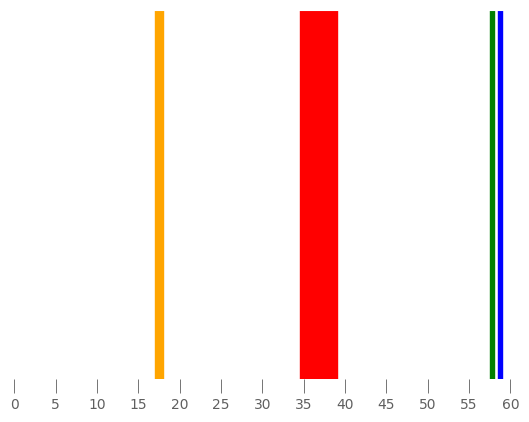

RCS07R
[[53 61]
 [21 29]
 [80 80]
 [72 75]]


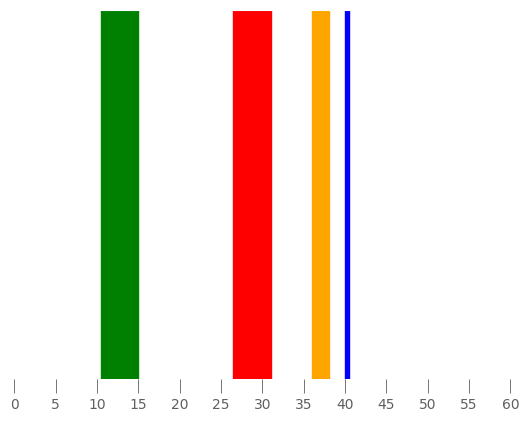

RCS09L
[[101 106]
 [  7   7]
 [  5   5]
 [  4   5]]


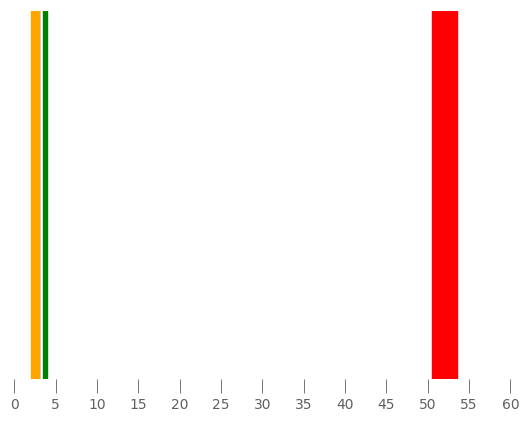

RCS09R
[[20 28]
 [43 51]
 [ 7 10]
 [53 61]]


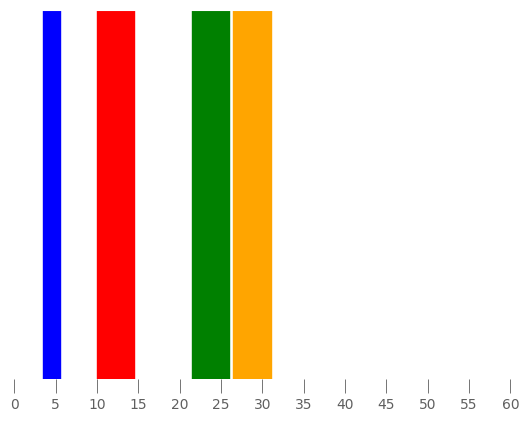

RCS16L
[[59 67]
 [18 22]
 [75 80]
 [50 58]]


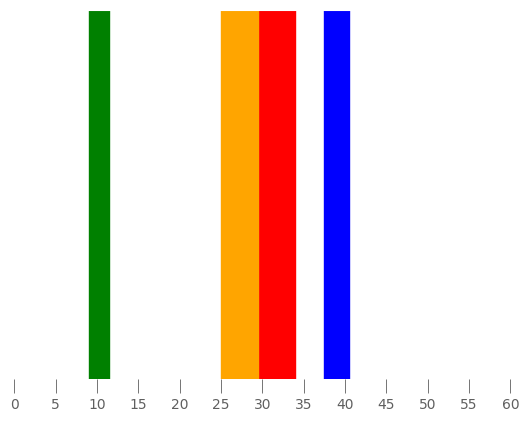

RCS16R
[[ 3  4]
 [ 2 10]
 [19 21]
 [69 77]]


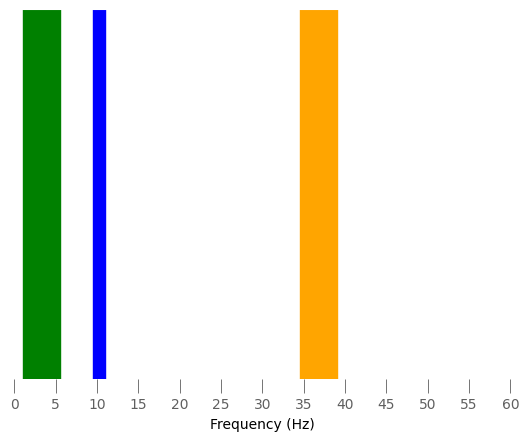

In [64]:
for i, key in enumerate(parts_sfs_sub.keys()):
    print(key)
    if i == len(parts_sfs_sub.keys()) - 1:
        plot_powerband(np.stack(parts_sfs_sub[key].select(pl.col('^.*_index$')).to_numpy()[0]), 512, 1, xlabel=True)
    else:
        plot_powerband(np.stack(parts_sfs_sub[key].select(pl.col('^.*_index$')).to_numpy()[0]), 512, 1, xlabel=False)

[[  3   4]
 [111 119]
 [100 108]
 [ 93 101]]


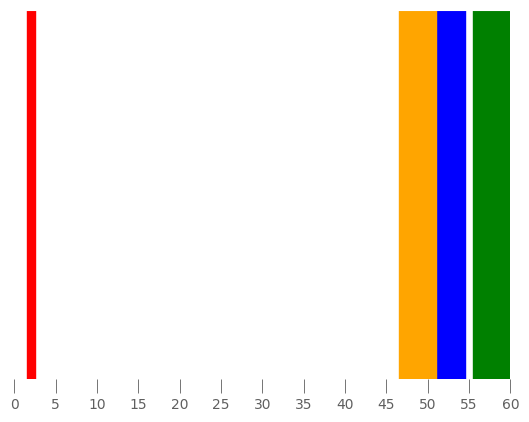

In [60]:
plot_powerband(np.stack(parts_sfs_cort['RCS02R'].select(pl.col('^.*_index$')).to_numpy()[0]), 512, 1)

In [99]:
# Get the scores of the canonical powerbands for each participant
# update_rate = 30
# db_path='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb'
# devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
# sleep_stage_mapping = {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}
# power_band_names = ['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
# model = LinearDiscriminantAnalysis()
# parameters = {"UpdateRate": update_rate, "model": model}
# cols_to_exclude = ['TD_BG'] 

def get_pbs_scores(**kwargs):
    for i, device in enumerate(devices):
        np.random.seed(seed=11)
        cv_results = {'test_accuracy': [], 'test_roc_auc': [], 'test_balanced_accuracy': [], 'test_recall': [], 'test_precision': []}
        scores_stds = {'test_accuracy': [], 'test_roc_auc': [], 'test_balanced_accuracy': [], 'test_recall': [], 'test_precision': []}
        df, df_training, settings = load_training_data_from_db(device, db_path, session_validation=True)
        print(power_band_names)
        pbs = [[int(ele) for ele in settings[pb][0].split('  ')] for pb in power_band_names]
        print(pbs)
        
        df_training = df_training.select(pl.col("^(SessionIdentity|fft_|Sleep).*$")).select(
            pl.exclude("|".join([f"^.*{col}.*$" for col in cols_to_exclude]))
        )
        
        # Remap sleep stages to binary classes
        df_training = df_training.with_columns(
            pl.col("SleepStage").map_dict(sleep_stage_mapping).alias("SleepStageBinary")
        )
        
        # Repeat above steps for the entire dataset
        df = df.select(pl.col("^(SessionIdentity|fft_|Sleep).*$")).select(
            pl.exclude("|".join([f"^.*{col}.*$" for col in cols_to_exclude]))
        )
        df = df.with_columns(
            pl.col("SleepStage").map_dict(sleep_stage_mapping).alias("SleepStageBinary")
        )

        fft_cols = [col for col in df_training.columns if "fft" in col]
        df_training = df_training.with_columns(
                        pl.col(fft_cols[0]).list.concat(pl.col(fft_cols[1:])).alias('fft_vec')
                    )
        
        X, y = get_training_data_for_model(
                df_training,
                pbs,
                update_rate,
                label_col="SleepStageBinary",
            )

        print(X.shape)
        
        cv_results_tmp = cross_validate(model, X, y, cv=5,
                    scoring=['accuracy', 'roc_auc', 'balanced_accuracy', 'recall', 'precision'])

        [cv_results[k].extend([np.mean(v)]) for (k, v) in cv_results_tmp.items() if k in cv_results.keys()]
        
        [
            scores_stds[k].extend([np.std(v)])
            for (k, v) in cv_results_tmp.items()
            if k in scores_stds.keys()
        ]
            
        sessions = df["SessionIdentity"].unique().to_list()
            
        # Create dict to store session validation scores
        session_scores = {
            "session_accuracy": [],
            "session_AUC": [],
            "session_recall": [],
            "session_precision": [],
            "validation_session": [],
        }
        
        # Concatenate FFT vectors into single column to simplify powerband calculations
        df = df.with_columns(
                        pl.col(fft_cols[0]).list.concat(pl.col(fft_cols[1:])).alias('fft_vec')
                    )
        
        
        # Get the scores for the validation session
        # TODO: Make sure last index in PB is included...
        session_cross_validate = leave_one_session_out_cross_validation(
            df, sessions, pbs, parameters
        )

        session_scores["session_accuracy"].append(
            session_cross_validate["Accuracy"]
        )
        session_scores["session_AUC"].append(
            session_cross_validate["AUC"]
        )
        session_scores["session_precision"].append(
            session_cross_validate["Precision"]
        )
        session_scores["session_recall"].append(
            session_cross_validate["Recall"]
        )
        session_scores["validation_session"].append(
            session_cross_validate["Validation_Session"]
        )
        
        scores_std_df = pl.DataFrame(scores_stds).rename({'test_accuracy': 'Acc_std', 'test_roc_auc': 'AUC_std', 'test_balanced_accuracy': 'BalAcc_std', 'test_recall': 'TPR_std', 'test_precision': 'precision_std'})
        
        if i == 0:
            df_scores = pl.concat([pl.DataFrame({**cv_results, 'device': device} | {**session_scores}) , scores_std_df], how='horizontal')
        else:
            df_tmp = pl.concat([pl.DataFrame({**cv_results, 'device': device} | {**session_scores}) , scores_std_df], how='horizontal')
            df_scores = pl.concat([df_scores, df_tmp], how='vertical')

    df_scores = df_scores.with_columns(
            [
                pl.col("^session.*$").list.mean().suffix("_mean"),
                pl.col("^session.*$")
                .apply(lambda x: np.std(x.to_list()))
                .suffix("_std"),
            ]
        )

    return df_scores

In [93]:
baselines_base_path = '/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/baselines/'

In [100]:
model = LinearDiscriminantAnalysis()
update_rate = 30
power_band_names = ['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
sleep_stage_mapping = {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
db_path='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb'
parameters = {"UpdateRate": update_rate, "model": model}
cols_to_exclude = ['TD_BG']

df_scores_baseline = get_pbs_scores(
    db_path=db_path,
    devices = devices,
    sleep_stage_mapping = sleep_stage_mapping,
    power_band_names = power_band_names,
    model = model,
    parameters = parameters,
    cols_to_exclude = cols_to_exclude
)

df_scores_baseline.write_parquet(f'{baselines_base_path}/sls_baseline.parquet')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6410, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6120, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6805, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5442, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4020, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5199, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4780, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4322, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6085, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5006, 4)


In [101]:
power_band_names=['Power_Band5_indices']
df_scores_delta = get_pbs_scores(update_rate = update_rate,
    db_path=db_path,
    devices = devices,
    sleep_stage_mapping = sleep_stage_mapping,
    power_band_names = power_band_names,
    model = model,
    parameters = parameters,
    cols_to_exclude = cols_to_exclude
)

df_scores_delta.write_parquet(f"{baselines_base_path}/sls_delta.parquet")

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(6410, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(6120, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(6805, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(5442, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(4020, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(5199, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(4780, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(4322, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(6085, 1)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices']
[[3, 9]]
(5006, 1)


In [102]:
power_band_names = ['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
sleep_stage_mapping = {2: 0, 3: 0, 4: 0, 5: 1, 6: 0}

df_scores_rem = get_pbs_scores(
    db_path=db_path,
    devices = devices,
    sleep_stage_mapping = sleep_stage_mapping,
    power_band_names = power_band_names,
    model = model,
    parameters = parameters,
    cols_to_exclude = cols_to_exclude
)

df_scores_rem.write_parquet(f'{baselines_base_path}/rem_baselines.parquet')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6410, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6120, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6805, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5442, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4020, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5199, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4780, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4322, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6085, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5006, 4)


In [103]:
model = DecisionTreeClassifier(max_leaf_nodes=3)
update_rate = 30
power_band_names = ['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
sleep_stage_mapping = {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
db_path='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb'
parameters = {"UpdateRate": update_rate, "model": model}
cols_to_exclude = ['TD_BG']

df_baseline_dt_sls = get_pbs_scores(
    db_path=db_path,
    devices = devices,
    sleep_stage_mapping = sleep_stage_mapping,
    power_band_names = power_band_names,
    model = model,
    parameters = parameters,
    cols_to_exclude = cols_to_exclude
)

df_baseline_dt_sls.write_parquet(f'{baselines_base_path}/baseline_dt_sls.parquet')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6410, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6120, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6805, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5442, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4020, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5199, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4780, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4322, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6085, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5006, 4)


In [104]:
model = TwoStepLDATree()
update_rate = 30
power_band_names = ['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
sleep_stage_mapping = {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
db_path='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb'
parameters = {"UpdateRate": update_rate, "model": model}
cols_to_exclude = ['TD_BG']

df_baseline_2lda_sls = get_pbs_scores(
    db_path=db_path,
    devices = devices,
    sleep_stage_mapping = sleep_stage_mapping,
    power_band_names = power_band_names,
    model = model,
    parameters = parameters,
    cols_to_exclude = cols_to_exclude
)

df_baseline_2lda_sls.write_parquet(f'{baselines_base_path}/baseline_2lda_sls.parquet')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6410, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6120, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6805, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5442, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4020, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5199, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4780, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4322, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6085, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5006, 4)


In [105]:
model = DecisionTreeClassifier(max_leaf_nodes=3)
update_rate = 30
power_band_names = ['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
sleep_stage_mapping = {2: 0, 3: 0, 4: 0, 5: 1, 6: 0}
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
db_path='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb'
parameters = {"UpdateRate": update_rate, "model": model}
cols_to_exclude = ['TD_BG']

df_baseline_dt_rem = get_pbs_scores(
    db_path=db_path,
    devices = devices,
    sleep_stage_mapping = sleep_stage_mapping,
    power_band_names = power_band_names,
    model = model,
    parameters = parameters,
    cols_to_exclude = cols_to_exclude
)

df_baseline_dt_rem.write_parquet(f'{baselines_base_path}/baseline_dt_rem.parquet')


model = TwoStepLDATree()

df_baseline_2lda_rem = get_pbs_scores(
    db_path=db_path,
    devices = devices,
    sleep_stage_mapping = sleep_stage_mapping,
    power_band_names = power_band_names,
    model = model,
    parameters = parameters,
    cols_to_exclude = cols_to_exclude
)

df_baseline_2lda_rem.write_parquet(f'{baselines_base_path}/baseline_2lda_rem.parquet')

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6410, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6120, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6805, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5442, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4020, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5199, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4780, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4322, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6085, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5006, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6410, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6120, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6805, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5442, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4020, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5199, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4780, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(4322, 4)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(6085, 4)


/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs/sleepclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claysmyth/miniconda3/envs

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

['Power_Band5_indices', 'Power_Band6_indices', 'Power_Band7_indices', 'Power_Band8_indices']
[[3, 9], [11, 26], [38, 62], [83, 130]]
(5006, 4)


In [22]:
df_scores

test_accuracy,test_roc_auc,test_balanced_accuracy,test_recall,test_precision,device,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std
f64,f64,f64,f64,f64,str,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64
0.904524,0.967811,0.903009,0.912553,0.922465,"""02L""","[0.902235, 0.907716, … 0.865443]","[0.962476, 0.9706, … 0.928812]","[0.906615, 0.945869, … 0.841975]","[0.954918, 0.887701, … 0.934247]","[""02L_04-28-22"", ""02L_04-30-22"", … ""02L_05-03-22""]",0.904073,0.966368,0.918618,0.920969,0.025775,0.017515,0.034943,0.035993
0.907843,0.965566,0.90806,0.907008,0.937312,"""02R""","[0.906667, 0.905473, … 0.937785]","[0.957743, 0.971103, … 0.985639]","[0.9, 0.905433, … 0.931694]","[0.968127, 0.939457, … 0.955182]","[""02R_04-28-22"", ""02R_04-27-22"", … ""02R_05-04-22""]",0.90347,0.965038,0.90321,0.940242,0.026299,0.016826,0.033196,0.036717
0.880235,0.942668,0.8809,0.873995,0.904367,"""03L""","[0.881127, 0.896392, … 0.829047]","[0.955009, 0.956934, … 0.945507]","[0.918854, 0.953571, … 0.765957]","[0.859375, 0.86129, … 0.95858]","[""03L_05-28-22"", ""03L_05-22-22"", … ""03L_05-25-22""]",0.859588,0.940841,0.780365,0.922343,0.05021,0.021212,0.250825,0.055252
0.869156,0.933886,0.870064,0.832389,0.90549,"""03R""","[0.92145, 0.792248, … 0.915493]","[0.968006, 0.889809, … 0.964662]","[0.847134, 0.585616, … 0.919003]","[0.985185, 0.929348, … 0.880597]","[""03R_05-21-22"", ""03R_05-26-22"", … ""03R_05-22-22""]",0.863757,0.931553,0.780569,0.926649,0.058652,0.039091,0.196459,0.042906
0.822388,0.902923,0.82015,0.837044,0.847516,"""07L""","[0.718696, 0.876797, … 0.888889]","[0.803948, 0.939414, … 0.953263]","[0.685811, 0.85489, … 0.910959]","[0.740876, 0.950877, … 0.95]","[""07L_05-12-22"", ""07L_05-25-22"", … ""07L_06-30-22""]",0.843331,0.901271,0.842904,0.873716,0.08255,0.066778,0.079306,0.093526
0.833047,0.910947,0.829494,0.868469,0.832981,"""07R""","[0.895782, 0.762943, … 0.662745]","[0.965682, 0.833601, … 0.940327]","[0.86087, 0.78271, … 0.992288]","[0.951923, 0.805288, … 0.602184]","[""07R_05-20-22"", ""07R_05-12-22"", … ""07R_06-30-22""]",0.819896,0.881763,0.835576,0.830349,0.091076,0.068276,0.099911,0.127553
0.825523,0.87995,0.818939,0.879898,0.819208,"""09L""","[0.792857, 0.894822, … 0.821114]","[0.899337, 0.959061, … 0.865104]","[0.806452, 0.905405, … 0.86722]","[0.872093, 0.878689, … 0.878151]","[""09L_11-22-22"", ""09L_07-26-22"", … ""09L_11-04-22""]",0.810026,0.919923,0.85465,0.845373,0.107917,0.043507,0.123819,0.155133
0.80356,0.847201,0.78947,0.922976,0.768298,"""09R""","[0.923729, 0.825607, … 0.791045]","[0.966322, 0.823479, … 0.895477]","[0.953947, 0.86533, … 0.857143]","[0.929487, 0.904192, … 0.83871]","[""09R_07-24-22"", ""09R_12-10-22"", … ""09R_11-22-22""]",0.79683,0.878609,0.908541,0.793562,0.094621,0.067408,0.068752,0.142402
0.818077,0.868867,0.806755,0.87738,0.822272,"""16L""","[0.665517, 0.836653, … 0.808937]","[0.731113, 0.888368, … 0.892436]","[0.920354, 0.856842, … 0.969789]","[0.541667, 0.880952, … 0.737931]","[""16L_04-30-22"", ""16L_05-10-22"", … ""16L_05-16-22""]",0.804338,0.866174,0.882162,0.798851,0.053273,0.054079,0.04096,0.108475


In [ ]:

# Find channels that can feasibly be embedded onto device

num = 5
for key in parts.keys():
    print(key)
    display(parts[key].filter(
                            pl.col('PB1').arr.concat(['PB2', 'PB3', 'PB4']).arr.eval(pl.element() > 511).arr.sum() == 4
    ).sort('AUC', descending=True).head(num))

In [35]:
[print(parts_sfs[key]['PB0_channel_freq_range']) for key in parts_sfs.keys()]

shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[0.73, 3.17]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[1.22, 3.17]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[0.73, 1.22]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[0.73, 1.22]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[1.22, 4.15]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[0.73, 5.13]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[0.73, 1.22]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[0.73, 1.71]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[0.73, 4.15]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[0.73, 3.17]}
]


[None, None, None, None, None, None, None, None, None, None]

In [83]:
[print(parts_sfs_rem[key]['PB0_channel_freq_range']) for key in parts_sfs.keys()]

shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[31.98, 36.38]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[31.98, 36.38]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_BG",[0.73, 1.22]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[8.06, 10.5]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[8.06, 11.47]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key3",[5.13, 9.52]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[12.94, 13.92]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[12.94, 13.43]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[53.96, 58.35]}
]
shape: (1,)
Series: 'PB0_channel_freq_range' [struct[2]]
[
	{"TD_key2",[13.43, 15.38]}
]


[None, None, None, None, None, None, None, None, None, None]

In [97]:
parts_sfs['RCS07L'].head()

PB0_index,PB1_index,PB2_index,PB3_index,sfs_scores,Acc,AUC,BalAcc,TPR,Precision,TNR,Acc_std,AUC_std,BalAcc_std,TPR_std,precision_std,TNR_std,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std,PB0_channel_freq_range,PB1_channel_freq_range,PB2_channel_freq_range,PB3_channel_freq_range
list[i64],list[i64],list[i64],list[i64],list[f64],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64,struct[2],struct[2],struct[2],struct[2]
"[1027, 1032]","[11, 12]","[514, 519]","[523, 523]","[0.892883, 0.89691, … 0.898995]",0.814925,0.898995,0.824784,0.750524,0.906084,0.899043,0.03293,0.021549,0.030269,0.051556,0.016642,0.014883,"[0.843943, 0.826816, … 0.701544]","[0.92789, 0.876953, … 0.815296]","[0.810726, 0.730627, … 0.581081]","[0.941392, 0.908257, … 0.774775]","[""07L_05-25-22"", ""07L_06-07-22"", … ""07L_05-12-22""]",0.836315,0.910056,0.785037,0.910759,0.087939,0.059526,0.12169,0.057163,"{""TD_key3"",[1.22, 4.15]}","{""TD_BG"",[5.13, 6.1]}","{""TD_key2"",[0.73, 3.66]}","{""TD_key2"",[5.13, 5.62]}"


In [53]:
df_scores_dd.head()

Participant,AUC,Session_AUC,Acc,Session_Acc
str,f64,f64,f64,f64
"""02L""",0.962678,0.959261,0.86131,0.861065
"""02R""",0.973467,0.971494,0.912908,0.910736
"""03L""",0.953942,0.948786,0.861572,0.845317
"""03R""",0.945429,0.94706,0.836633,0.827891
"""07L""",0.898995,0.910056,0.814925,0.836315


In [65]:
df_scores.head()

test_accuracy,test_roc_auc,test_balanced_accuracy,test_recall,test_precision,device,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std
f64,f64,f64,f64,f64,str,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64
0.904524,0.967811,0.903009,0.912553,0.922465,"""02L""","[0.902235, 0.907716, … 0.865443]","[0.962476, 0.9706, … 0.928812]","[0.906615, 0.945869, … 0.841975]","[0.954918, 0.887701, … 0.934247]","[""02L_04-28-22"", ""02L_04-30-22"", … ""02L_05-03-22""]",0.904073,0.966368,0.918618,0.920969,0.025775,0.017515,0.034943,0.035993
0.907843,0.965566,0.90806,0.907008,0.937312,"""02R""","[0.906667, 0.905473, … 0.937785]","[0.957743, 0.971103, … 0.985639]","[0.9, 0.905433, … 0.931694]","[0.968127, 0.939457, … 0.955182]","[""02R_04-28-22"", ""02R_04-27-22"", … ""02R_05-04-22""]",0.90347,0.965038,0.90321,0.940242,0.026299,0.016826,0.033196,0.036717
0.880235,0.942668,0.8809,0.873995,0.904367,"""03L""","[0.881127, 0.896392, … 0.829047]","[0.955009, 0.956934, … 0.945507]","[0.918854, 0.953571, … 0.765957]","[0.859375, 0.86129, … 0.95858]","[""03L_05-28-22"", ""03L_05-22-22"", … ""03L_05-25-22""]",0.859588,0.940841,0.780365,0.922343,0.05021,0.021212,0.250825,0.055252
0.869156,0.933886,0.870064,0.832389,0.90549,"""03R""","[0.92145, 0.792248, … 0.915493]","[0.968006, 0.889809, … 0.964662]","[0.847134, 0.585616, … 0.919003]","[0.985185, 0.929348, … 0.880597]","[""03R_05-21-22"", ""03R_05-26-22"", … ""03R_05-22-22""]",0.863757,0.931553,0.780569,0.926649,0.058652,0.039091,0.196459,0.042906
0.822388,0.902923,0.82015,0.837044,0.847516,"""07L""","[0.718696, 0.876797, … 0.888889]","[0.803948, 0.939414, … 0.953263]","[0.685811, 0.85489, … 0.910959]","[0.740876, 0.950877, … 0.95]","[""07L_05-12-22"", ""07L_05-25-22"", … ""07L_06-30-22""]",0.843331,0.901271,0.842904,0.873716,0.08255,0.066778,0.079306,0.093526


In [64]:
df_scores_delta.head()

test_accuracy,test_roc_auc,test_balanced_accuracy,test_recall,test_precision,device,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std
f64,f64,f64,f64,f64,str,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64
0.904524,0.967742,0.903112,0.912015,0.922946,"""02L""","[0.865443, 0.907716, … 0.915423]","[0.928812, 0.9706, … 0.972494]","[0.841975, 0.945869, … 0.921371]","[0.934247, 0.887701, … 0.940329]","[""02L_05-03-22"", ""02L_04-30-22"", … ""02L_04-27-22""]",0.904073,0.966368,0.918618,0.920969,0.025775,0.017515,0.034943,0.035993
0.908007,0.965635,0.908196,0.907281,0.937338,"""02R""","[0.856604, 0.928097, … 0.880231]","[0.938249, 0.982406, … 0.96047]","[0.833333, 0.893939, … 0.858247]","[0.963855, 0.981289, … 0.922438]","[""02R_05-03-22"", ""02R_04-22-22"", … ""02R_04-21-22""]",0.90347,0.965038,0.90321,0.940242,0.026299,0.016826,0.033196,0.036717
0.880235,0.942683,0.880843,0.874531,0.903901,"""03L""","[0.881127, 0.859954, … 0.84542]","[0.955009, 0.947754, … 0.911121]","[0.918854, 0.827094, … 0.91709]","[0.859375, 0.95082, … 0.827481]","[""03L_05-28-22"", ""03L_05-20-22"", … ""03L_05-23-22""]",0.859588,0.940841,0.780365,0.922343,0.05021,0.021212,0.250825,0.055252
0.869339,0.933883,0.870236,0.832356,0.90583,"""03R""","[0.915493, 0.926582, … 0.876165]","[0.964662, 0.969968, … 0.93727]","[0.919003, 0.917051, … 0.892019]","[0.880597, 0.947619, … 0.88993]","[""03R_05-22-22"", ""03R_05-28-22"", … ""03R_05-27-22""]",0.863757,0.931553,0.780569,0.926649,0.058652,0.039091,0.196459,0.042906
0.821642,0.902987,0.819351,0.836654,0.84669,"""07L""","[0.888889, 0.756257, … 0.755889]","[0.953263, 0.802937, … 0.855947]","[0.910959, 0.785266, … 0.8125]","[0.95, 0.852041, … 0.738636]","[""07L_06-30-22"", ""07L_07-26-22"", … ""07L_07-22-22""]",0.843331,0.901271,0.842904,0.873716,0.08255,0.066778,0.079306,0.093526


<AxesSubplot:xlabel='Participant', ylabel='AUC'>

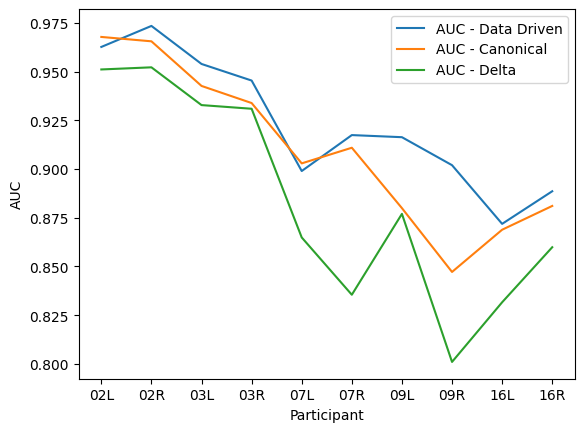

In [78]:
sns.lineplot(data=df_scores_dd, x='Participant', y='AUC', label='AUC - Data Driven')
sns.lineplot(data=df_scores, x='device', y='test_roc_auc', label='AUC - Canonical')
sns.lineplot(data=df_scores_delta, x='device', y='test_roc_auc', label='AUC - Delta')

<AxesSubplot:xlabel='Participant', ylabel='Session_AUC'>

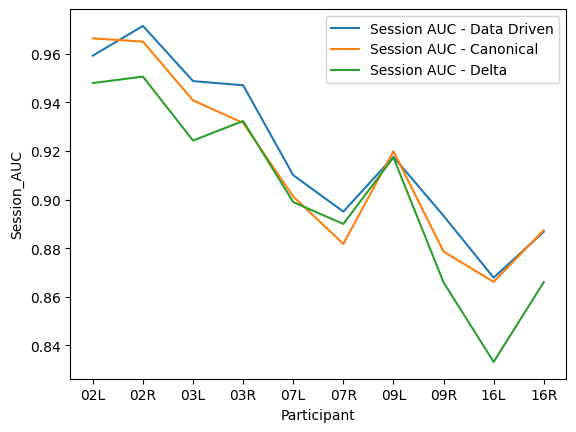

In [79]:
sns.lineplot(data=df_scores_dd, x='Participant', y='Session_AUC', label='Session AUC - Data Driven')
sns.lineplot(data=df_scores, x='device', y='session_AUC_mean', label='Session AUC - Canonical')
sns.lineplot(data=df_scores_delta, x='device', y='session_AUC_mean', label='Session AUC - Delta')


<AxesSubplot:xlabel='Participant', ylabel='Acc'>

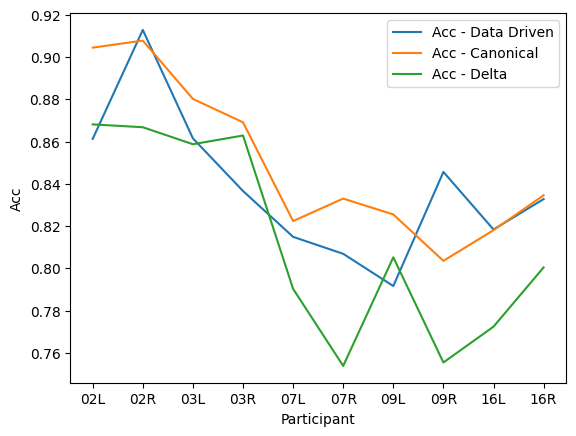

In [80]:
sns.lineplot(data=df_scores_dd, x='Participant', y='Acc', label='Acc - Data Driven')
sns.lineplot(data=df_scores, x='device', y='test_accuracy', label='Acc - Canonical')
sns.lineplot(data=df_scores_delta, x='device', y='test_accuracy', label='Acc - Delta')

<AxesSubplot:xlabel='Participant', ylabel='Session_Acc'>

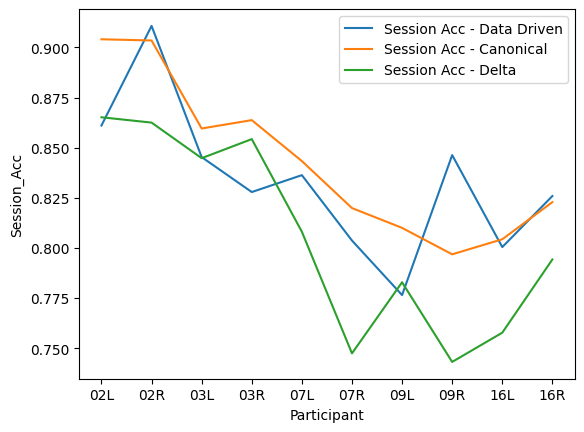

In [81]:
sns.lineplot(data=df_scores_dd, x='Participant', y='Session_Acc', label='Session Acc - Data Driven')
sns.lineplot(data=df_scores, x='device', y='session_accuracy_mean', label='Session Acc - Canonical')
sns.lineplot(data=df_scores_delta, x='device', y='session_accuracy_mean', label='Session Acc - Delta')

In [102]:
df_scores_rem.head()

test_accuracy,test_roc_auc,test_balanced_accuracy,test_recall,test_precision,device,session_accuracy,session_AUC,session_recall,session_precision,validation_session,session_accuracy_mean,session_AUC_mean,session_recall_mean,session_precision_mean,session_accuracy_std,session_AUC_std,session_recall_std,session_precision_std
f64,f64,f64,f64,f64,str,list[f64],list[f64],list[f64],list[f64],list[str],f64,f64,f64,f64,f64,f64,f64,f64
0.853198,0.718086,0.499088,0.0,0.0,"""02L""","[0.876516, 0.869565, … 0.868235]","[0.728841, 0.692036, … 0.67251]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","[""02L_04-22-22"", ""02L_05-04-22"", … ""02L_04-21-22""]",0.85714,0.719333,0.001042,0.033333,0.042602,0.033735,0.003125,0.1
0.855392,0.781321,0.495033,0.007539,0.061111,"""02R""","[0.784848, 0.870794, … 0.920918]","[0.780276, 0.793383, … 0.813787]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","[""02R_04-30-22"", ""02R_05-05-22"", … ""02R_05-06-22""]",0.864874,0.768283,0.00444,0.109091,0.045681,0.038977,0.010351,0.298204
0.80867,0.729645,0.500242,0.006271,0.140598,"""03L""","[0.780637, 0.756173, … 0.829681]","[0.733535, 0.644178, … 0.761232]","[0.00565, 0.0, … 0.02454]","[0.25, 0.0, … 0.25]","[""03L_05-28-22"", ""03L_05-21-22"", … ""03L_05-26-22""]",0.805741,0.740937,0.005999,0.15,0.044063,0.040236,0.008059,0.171391
0.798603,0.756402,0.506653,0.034648,0.311587,"""03R""","[0.923875, 0.768537, … 0.933535]","[0.623947, 0.766604, … 0.619195]","[0.0, 0.021739, … 0.0]","[0.0, 0.454545, … 0.0]","[""03R_05-19-22"", ""03R_05-23-22"", … ""03R_05-21-22""]",0.812775,0.734788,0.018811,0.267056,0.072872,0.066156,0.024648,0.307306
0.857214,0.857325,0.708422,0.469006,0.681677,"""07L""","[0.783985, 0.829832, … 0.890098]","[0.807577, 0.957149, … 0.853839]","[0.242647, 0.536443, … 0.253333]","[0.717391, 0.983957, … 0.296875]","[""07L_06-07-22"", ""07L_06-09-22"", … ""07L_07-26-22""]",0.834198,0.839065,0.426603,0.625063,0.056174,0.087926,0.203571,0.205638


<AxesSubplot:xlabel='Participant', ylabel='AUC'>

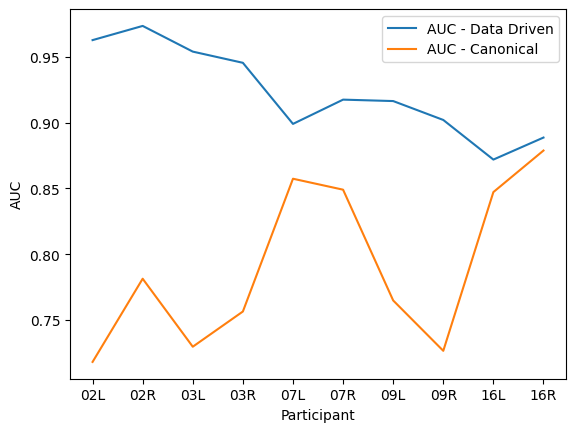

In [86]:
ax = sns.lineplot(data=df_scores_rem_dd, x='Participant', y='AUC', label='AUC - Data Driven')
ax.fill_between(df_scores_rem_dd['Participant'], df_scores_rem_dd['AUC'] - df_scores_rem_dd['AUC_std'], df_scores_rem_dd['AUC'] + df_scores_rem_dd['AUC_std'], alpha=0.2)
sns.lineplot(data=df_scores_rem, x='device', y='test_roc_auc', label='AUC - Canonical')

<AxesSubplot:xlabel='Participant', ylabel='Session_Acc'>

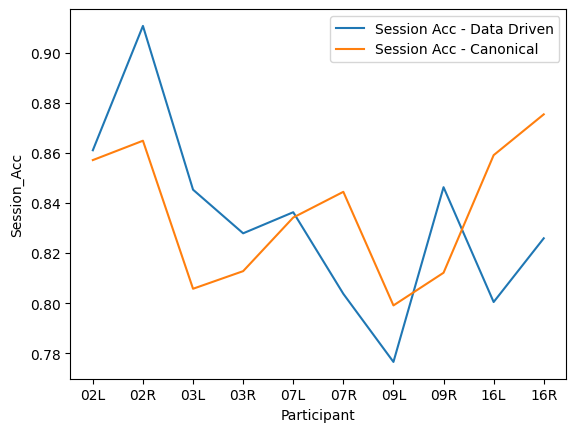

In [94]:
sns.lineplot(data=df_scores_rem_dd, x='Participant', y='Session_Acc', label='Session Acc - Data Driven')
sns.lineplot(data=df_scores_rem, x='device', y='session_accuracy_mean', label='Session Acc - Canonical')

In [92]:
parts_sfs_rem['RCS09L']['session_AUC'].to_numpy()

array([array([0.74318508, 0.88258278, 0.74460784, 0.94136782, 0.7311196 ,
              0.94586825, 0.95047584, 0.84761829])                       ],
      dtype=object)

[1 2 3 4]
[0.96053835 0.96252783 0.96281996 0.96267842]
[1 2 3 4]
[0.96263403 0.96982726 0.97212138 0.97346684]
[1 2 3 4]
[0.9489614  0.95092613 0.95311537 0.95394233]
[1 2 3 4]
[0.94467623 0.94566495 0.94569998 0.94542904]
[1 2 3 4]
[0.89288278 0.89690995 0.89853518 0.8989949 ]
[1 2 3 4]
[0.91221501 0.91610934 0.9170691  0.91743985]
[1 2 3 4]
[0.91541687 0.91570472 0.91635761 0.91635821]
[1 2 3 4]
[0.86943044 0.88749776 0.89754998 0.90199399]
[1 2 3 4]
[0.84745013 0.86153828 0.87028898 0.87187687]
[1 2 3 4]
[0.86190751 0.87889098 0.88658841 0.88861454]


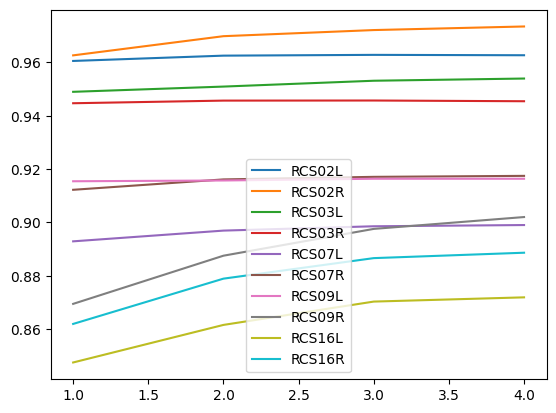

In [46]:
for key, df in parts_sfs.items():
    scores = df['sfs_scores'].to_numpy().squeeze()
    print(np.arange(1,5))
    print(scores)
    sns.lineplot(x=np.arange(1,5), y=scores, label=key)
plt.show()